## Combining ML1 ML2 and ML4 dataset after removing Batch Effect
### Experiments:
1. Z-score normalization independently on each dataset and combine dataset with stratified (label and batch).
2. Split the model 60/40 train the model and test

In [64]:
import warnings
warnings.filterwarnings('ignore')

import sys
import os
import pandas as pd
import numpy as np

sys.path.insert(0, '../')

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.base import clone
from sklearn.metrics import r2_score

from src.load_dataset import load_dataset
from src.utils import tsen_pca_viz, verify_batch_label_dist, calculate_r2_score, calculate_per_diff, per_error, find_adj_score, perform_combat_normalization
from src.load_models import select_model
from src.graph_visualization import visualization_testing_dataset
from src.config import *

In [36]:
# Load dataset
normalization    = True
standardize_type = 'mean_std' if normalization else 'none'
split            = True
combat_norm      = True


if split:
    (ML1_X_train, ML1_X_test, ML1_y_train, ML1_y_test), _  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_19_ML1', normalization=normalization, standardize_type=standardize_type, split=split)
    (ML2_X_train, ML2_X_test, ML2_y_train, ML2_y_test), _  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_22_ML2', normalization=normalization, standardize_type=standardize_type, split=split)
    (ML4_X_train, ML4_X_test, ML4_y_train, ML4_y_test), _  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML4', normalization=normalization, standardize_type=standardize_type, split=split)

else:
    ML1_X, ML1_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_19_ML1', normalization=normalization, standardize_type=standardize_type, split=split)
    ML2_X, ML2_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_22_ML2', normalization=normalization, standardize_type=standardize_type, split=split)
    ML4_X, ML4_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML4', normalization=normalization, standardize_type=standardize_type, split=split)


######Data Distribution:#########
Training {0: 27, 8: 25, 16: 26}
Testing {16: 18, 0: 17, 8: 17}
#################################
######Data Distribution:#########
Training {0: 24, 8: 21, 16: 24}
Testing {0: 16, 16: 16, 8: 15}
#################################
######Data Distribution:#########
Training {0: 23, 8: 25, 16: 21}
Testing {0: 15, 8: 16, 16: 15}
#################################


In [3]:
df = pd.DataFrame([ML1_X_test.mean(axis=0).values, ML2_X_test.mean(axis=0).values, ML4_X_test.mean(axis=0).values], columns=ML1_X_test.columns).round(5)
df.index= ['ML1', 'ML2', 'ML4']
df

,"univariate, area(S)",peak curvature,"univariate, V_max(S)",vcenter,"univariate, max(S)","univariate, mean(S)","univariate, std(S)","univariate, max(dS/dV)","univariate, min(dS/dV)","univariate, max(dS/dV) - min(dS/dV)","univariate, V_max(dS/dV)","univariate, V_min(dS/dV)","univariate, area(dS/dV)"
ML1,0.12950,0.05843,-0.02557,-0.07528,0.10329,0.13076,0.10595,0.08654,-0.11095,0.09972,-0.22919,0.13475,0.10333
ML2,-0.00830,-0.00741,-0.24958,0.01885,0.00474,-0.00822,-0.00322,0.01169,-0.06804,0.04201,0.05006,0.02473,0.00460
ML4,0.00493,0.00368,0.09575,0.18622,0.01983,0.00535,0.00743,0.02952,-0.04404,0.03785,-0.16600,0.18082,0.01979


In [4]:
df = pd.DataFrame([ML1_X_test.std(axis=0).values, ML2_X_test.std(axis=0).values, ML4_X_test.std(axis=0).values], columns=ML1_X_test.columns).round(5)
df.index= ['ML1', 'ML2', 'ML4']
df

,"univariate, area(S)",peak curvature,"univariate, V_max(S)",vcenter,"univariate, max(S)","univariate, mean(S)","univariate, std(S)","univariate, max(dS/dV)","univariate, min(dS/dV)","univariate, max(dS/dV) - min(dS/dV)","univariate, V_max(dS/dV)","univariate, V_min(dS/dV)","univariate, area(dS/dV)"
ML1,0.96649,1.03856,0.99191,0.98525,0.98737,0.96699,0.99199,0.99208,1.00866,0.99968,1.18277,0.76339,0.98739
ML2,0.98246,0.99046,1.39412,1.01600,1.00279,0.98121,1.00018,1.01970,1.05773,1.04023,0.89150,1.00402,1.00284
ML4,1.03253,1.08707,0.88672,1.10064,1.05590,1.03197,1.06167,1.08289,1.09238,1.08857,0.99703,0.77637,1.05593


[(0, 78), (78, 147), (147, 216)]


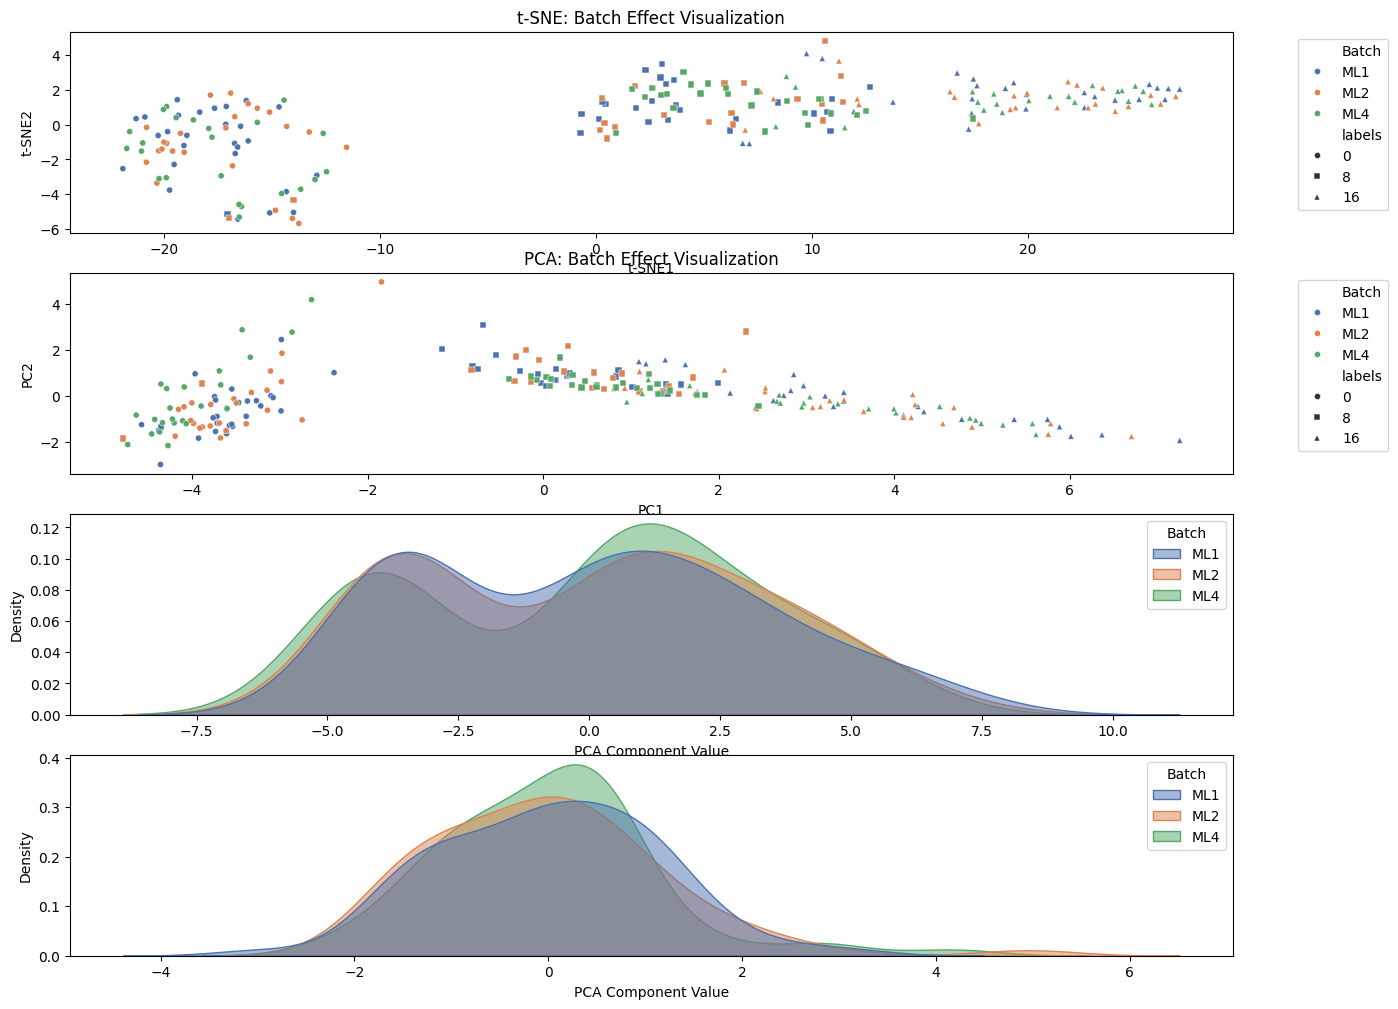

In [6]:
if combat_norm:
    (ML1_X_train, ML2_X_train, ML4_X_train), batch_labels, combat = perform_combat_normalization([ML1_X_train, ML2_X_train, ML4_X_train], dataset_name=['ML1', 'ML2', 'ML4'])
    labels               = ML1_y_train.values.tolist() + ML2_y_train.values.tolist() + ML4_y_train.values.tolist()
    tsen_pca_viz([ML1_X_train, ML2_X_train, ML4_X_train], batch_labels, labels)

    

50      0
94      8
65      8
43      0
31     16
       ..
92      8
18      8
128     8
127    16
47      0
Name: file, Length: 78, dtype: int64

It seems the mean is nearly equal to zero and std is 1

In [60]:
# perform stratified train test split
if split==False:
    X                = pd.concat([ML1_X, ML2_X, ML4_X], axis=0)
    y                = ML1_y.values.tolist() + ML2_y.values.tolist() + ML4_y.values.tolist()
    stratified_label = ML1_y.map(lambda x: f'ML1_{x}').values.tolist() + ML2_y.map(lambda x: f'ML2_{x}').values.tolist() + ML4_y.map(lambda x: f'ML4_{x}').values.tolist()
    
    X_train, X_test, y_train_strat, y_test_strat = train_test_split(X, stratified_label, test_size=0.4, shuffle=True, random_state=20, stratify=stratified_label)
    y_train, y_test = pd.Series(y_train_strat).map(lambda x: eval(x.split('_')[1])), pd.Series(y_test_strat).map(lambda x: eval(x.split('_')[1]))

else:
    y_train_strat = ML1_y_train.map(lambda x: f'ML1_{x}').values.tolist() + ML2_y_train.map(lambda x: f'ML2_{x}').values.tolist() + ML4_y_train.map(lambda x: f'ML4_{x}').values.tolist()
    y_test_strat  = ML1_y_test.map(lambda x: f'ML1_{x}').values.tolist() + ML2_y_test.map(lambda x: f'ML2_{x}').values.tolist() + ML4_y_test.map(lambda x: f'ML4_{x}').values.tolist()

    # Combine ML1, ML2, and ML4 dataset
    X_train, X_test, y_train, y_test =  pd.concat([ML1_X_train, ML2_X_train, ML4_X_train], axis=0).reset_index(drop=True), \
                                        pd.concat([ML1_X_test,  ML2_X_test,  ML4_X_test],  axis=0).reset_index(drop=True), \
                                        pd.concat([ML1_y_train, ML2_y_train, ML4_y_train], axis=0).reset_index(drop=True), \
                                        pd.concat([ML1_y_test,  ML2_y_test,  ML4_y_test],  axis=0).reset_index(drop=True)

    # Create shuffling index with random choice
    shuffle_ind_train = np.random.choice(range(len(X_train)), len(X_train), replace=False)
    assert len(np.unique(shuffle_ind_train))==len(X_train)
    
    shuffle_ind_test = np.random.choice(range(len(X_test)), len(X_test), replace=False)
    assert len(np.unique(shuffle_ind_test))==len(X_test)

    # Shuffle training dataset
    X_train, y_train = X_train.iloc[shuffle_ind_train], y_train.iloc[shuffle_ind_train]
    X_test,  y_test  = X_test.iloc[shuffle_ind_test],   y_test.iloc[shuffle_ind_test]

    # Check if the labels and features have same index after shuffling
    assert X_train.index.tolist()==y_train.index.tolist()
    assert X_test.index.tolist()==y_test.index.tolist()
    

In [61]:
X_train

,"univariate, area(S)",peak curvature,"univariate, V_max(S)",vcenter,"univariate, max(S)","univariate, mean(S)","univariate, std(S)","univariate, max(dS/dV)","univariate, min(dS/dV)","univariate, max(dS/dV) - min(dS/dV)","univariate, V_max(dS/dV)","univariate, V_min(dS/dV)","univariate, area(dS/dV)"
85,-0.847008,-0.904750,-1.453709,-1.647329,-0.937914,-0.837053,-0.918190,-0.973362,0.976448,-0.977668,-2.233262,-0.676989,-0.937636
155,1.890997,1.860740,0.540597,0.797403,1.880585,1.884087,1.906667,1.874752,-1.912592,1.897884,0.331992,0.615822,1.880504
68,0.151787,-0.067046,0.605732,0.815521,0.156338,0.163613,0.132717,0.113209,-0.082394,0.096908,0.840978,0.543315,0.156889
65,1.188296,1.264597,0.478579,0.489313,1.106848,1.199054,1.138448,0.991837,-0.873243,0.929900,0.408475,0.430905,1.106705
77,-0.982221,-1.472035,-0.475074,-0.652417,-1.017761,-0.975372,-1.035556,-1.006698,1.064859,-1.039222,-1.754039,0.318495,-1.018266
...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,-1.328711,-0.946736,-3.750937,-1.647329,-1.218889,-1.321759,-1.225498,-1.124754,1.063148,-1.094645,0.268282,-2.858606,-1.218967
109,-1.078272,-1.208932,-2.293881,-1.647329,-1.105585,-1.066651,-1.126366,-1.092946,1.054804,-1.075415,-1.732954,-0.420329,-1.105262
107,-1.092781,-1.036825,-1.571031,-1.647329,-1.111866,-1.092161,-1.126366,-1.094276,1.065258,-1.081653,-1.357722,-0.548659,-1.112296
38,-0.007158,-0.014666,0.484936,0.652417,-0.016655,-0.017589,-0.029825,0.056941,0.215200,-0.088436,0.408475,0.430905,-0.016355


## Verify training and testing distribution

In [62]:
# Verify the percentage of labels and batch
train_dist = verify_batch_label_dist(y_train_strat)
test_dist  = verify_batch_label_dist(y_test_strat)

print(train_dist)
print(test_dist)

              y
batch label    
ML1   0      27
      16     26
      8      25
ML2   0      24
      16     24
      8      21
ML4   0      23
      16     21
      8      25
              y
batch label    
ML1   0      17
      16     18
      8      17
ML2   0      16
      16     16
      8      15
ML4   0      15
      16     15
      8      16


In [63]:
# List of models
models = ['Linear', 'KNN', 'SVM', 'RF', 'GP', 'Ridge', 'Lasso', 'univariate, std(S)', 'univariate, max(dS/dV)', 'univariate, area(dS/dV)', 'univariate, area(S)', 'univariate, max(S)']

# Calcualte y_LOD
y_LOD = 0.9117010154341669 #calculate_y_LOD(X_testing, y_testing)
#print("y_LOD", y_LOD)

kf = KFold(n_splits=5)

r2_score_val,  per_diff_val  = {'Models':[], 'Scores':[]}, {'Models':[], 'Scores':[]}
r2_score_test, per_diff_test = {'Models':[], 'Scores':[]}, {'Models':[], 'Scores':[]}

for model_name in models:
    model    = select_model(model_name)

    val_r2     = calculate_r2_score(model, X_train[models_features_r2[model_name]],  y_train, kf)
    val_per    = calculate_per_diff(model, X_train[models_features_per[model_name]], y_train, kf, y_LOD)

    r2_score_val['Scores'].append(val_r2)
    per_diff_val['Scores'].append(val_per)

    model_r2  = clone(model)
    model_r2.fit(X_train[models_features_r2[model_name]], y_train)
    y_pred_r2 = model_r2.predict(X_test[models_features_r2[model_name]])

    r2_test_score = r2_score(y_test, y_pred_r2)
    adj_r2_test   = find_adj_score(len(y_pred_r2), len(models_features_r2[model_name]), r2_test_score)
    
    r2_score_test['Scores'].append((r2_test_score, adj_r2_test))

    model_per_diff = clone(model)
    model_per_diff.fit(X_train[models_features_per[model_name]], y_train)
    y_pred_per_diff = model_per_diff.predict(X_test[models_features_per[model_name]])
    
    per_diff_test['Scores'].append(per_error(y_test, y_pred_per_diff, y_LOD))

    r2_score_val['Models'].append(model_name)
    per_diff_val['Models'].append(model_name) 
    r2_score_test['Models'].append(model_name)
    per_diff_test['Models'].append(model_name)


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.069e+02, tolerance: 7.342e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.696e+02, tolerance: 7.296e-01
  model = cd_fast.enet_coordinate_descent(
/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

In [65]:
savedir   = f'../results/combined_ML1_ML2_ML4/{standardize_type}_{combat_norm}'
adj_score = False

os.makedirs(savedir, exist_ok=True)

visualization_testing_dataset(r2_score_val,  f'{savedir}/r2_score_val.png',   model_name_conversion, only_one_multivariate=False, adj_score=adj_score, legends=True)
visualization_testing_dataset(per_diff_val, f'{savedir}/per_error_val.png', model_name_conversion, only_one_multivariate=False, r2_score=False, adj_score=False, legends=True)

visualization_testing_dataset(r2_score_test,  f'{savedir}/r2_score_test.png',   model_name_conversion, only_one_multivariate=False, adj_score=adj_score, legends=True)
visualization_testing_dataset(per_diff_test, f'{savedir}/per_error_test.png', model_name_conversion, only_one_multivariate=False, r2_score=False, adj_score=False, legends=True)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>